# Computational Social Science: word2vec

In this lab we will use the techniques we introduce word embeddings via word2vec.

In [ ]:
#!pip install gensim
#!pip install tqdm
#!pip install adjustText
#!pip install multiprocessing

In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from tqdm import tqdm

import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data

<img src = "../../images/cfpb logo.png"  />

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "mortgage" issue or a "student loan" issue.

In [2]:
cfpb = pd.read_csv("../../data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000].reset_index(drop = True)

## Overview <a id='context'></a>

In this lab, we will be turning individual words in the data set into vectors, called "Word Embeddings". Word embedding attempt to identify semantic relationships between words by observing them in the context that the word appears. Word2Vec is the most prominent word embedding algorithm.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features

* `size`: Number of dimensions for word embedding model
* `window`: Number of context words to observe in each direction
* `min_count`: Minimum frequency for words included in model
* `sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram
* `alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning
* `iterations`: Number of passes through dataset
* `batch_words`: Number of words to sample from data during each pass


For more detailed background on Word2Vec's mechanics, I suggest this  <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

We will be using the default value for most of our parameters.

## Preprocessing

First let's use our handy preprocessing function. Notice that this version will return a list of tokens (not a string), and we also added the `str.lower()` method.

In [3]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # Using the bitwise |= (or) operator
    nlp.Defaults.stop_words |= {"xx", "xxxx","xxxxxxxx"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [4]:
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb['tokens']

0      [contacting, ocwen, mortgage, phh, mortgage, a...
1      [purchased, house, assignment, deed, trust, si...
2      [past, issues, mortgage, solutions, colorado, ...
3      [called, nationstar, multiple, times, request,...
4      [documents, short, sale, review, sent, xxxx20,...
                             ...                        
995    [contacted, offering, complete, application, l...
996    [parent, plus, loan, opened, children, start, ...
997    [tcf, refusing, provide, account, information,...
998    [asking, loan, modification, years, particular...
999    [loan, bayview, loan, services, went, 3,  , 72...
Name: tokens, Length: 1000, dtype: object

## Model Training

Now that we have pre-processed our text, we can use the [`gensim`](https://radimrehurek.com/gensim/) library to construct our word embeddings. We will use the Continous Bag of Words model (CBOW), which predicts target words from its neighboring context words to learn word embeddings from raw text.

Read through the documentation of the Word2Vec method in gensim to understand how to implement the Word2Vec model. Then fill in the blanks so that: we use a __Continuout Bag of Words__ model to create word embeddings of __size 100__ for words that appear in `text` __5 or more times__. Set the learning rate to .025, number of iterations to 5, and sample 10000 words from the data during each pass.

In [5]:
model = gensim.models.Word2Vec(cfpb['tokens'], size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

## Embeddings <a id='subsection 2'></a>

Now that we've trained the mode, we can return the actual high-dimensional vector by simply indexing the model with the word as the key:

In [6]:
# New syntax as of gensim 4.0.0
# model['account'] works for 3.8.3
print(model.wv.__getitem__(['account']))

[[ 0.12244737  0.29483145 -0.59485346 -0.0445887  -0.5018655  -0.03187447
  -0.57955146 -0.624534    0.44568485 -0.05946297  0.17875576 -0.1935393
  -0.11606909  0.21975474  0.08005719  0.05235553  0.6024572   0.3327405
  -0.03819817 -0.08243372  0.2467714   0.6306272   0.04815705 -0.05932864
  -0.03880182  0.36097226  0.08762728  0.20951365 -0.26004422  0.14667934
   0.31064847 -0.60406846 -0.33058494 -0.34805337 -0.38587287 -0.16987504
  -0.72271097  0.3542334   0.05873494 -0.5079929  -0.3581958   0.24914189
  -0.5478051   0.12558419 -0.08148678  0.11926547 -0.28616306  0.19071698
  -0.0368749   0.04199774 -0.04704374  0.44354007 -0.04864344  0.2053417
   0.6169799   0.28320605 -0.20826848 -0.06311759  0.09313887 -0.18153739
   0.13121049 -0.29993698  0.13224557  0.4141337  -0.1792933  -0.31226555
  -0.369606    0.6208681  -0.2062049   0.18146835  0.20618588 -0.301527
  -0.6796772  -0.20087793  0.44774425 -0.1832443   0.25437313 -0.23197801
  -0.27988377 -0.10639008  0.20229328  0.19

Check out the shape of the vectors for 'account', what do you notice?

In [7]:
model.wv.__getitem__(['account']).shape

(1, 100)

**Answer**: There are 100 elements in this array. Notice that this was one of the parameters we set in the training process!

Use the following empty cells to look at what the word embeddings look like for words you think may appear in the text! Keep in mind that even if a word shows up in the text as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. 

In [8]:
# word 1
model.wv.__getitem__(['navient'])

array([[ 0.20190619,  0.22563897, -0.5432452 ,  0.04323281, -0.50355905,
        -0.01444298, -0.62239146, -0.56237787,  0.51920044, -0.09057207,
         0.19620593, -0.27200845, -0.19752754,  0.15679067,  0.05068109,
         0.06859015,  0.5976758 ,  0.3859615 , -0.04437149, -0.14357297,
         0.1592544 ,  0.5174943 ,  0.05428516, -0.16710235, -0.07380657,
         0.40477258,  0.01684676,  0.16177705, -0.26235917,  0.22226694,
         0.37551367, -0.61544585, -0.3445224 , -0.3723163 , -0.5013718 ,
        -0.15845764, -0.7128661 ,  0.3452946 ,  0.10226661, -0.57471114,
        -0.38344675,  0.17926893, -0.6086031 ,  0.10362082, -0.06225697,
         0.09267442, -0.33431792,  0.1833677 , -0.06184337,  0.0213593 ,
        -0.07209425,  0.43866828, -0.04664808,  0.13044596,  0.61530554,
         0.28187102, -0.15221345, -0.05314868,  0.1402516 , -0.19109797,
         0.17648792, -0.23925741,  0.1470646 ,  0.41747668, -0.18030943,
        -0.26639196, -0.35072705,  0.622244  , -0.1

In [9]:
# word 2
model.wv.__getitem__(['company'])

array([[ 0.13373594,  0.22758201, -0.5685295 ,  0.02491936, -0.4977827 ,
        -0.02514713, -0.59004194, -0.5915517 ,  0.4423753 , -0.10162969,
         0.22163057, -0.253268  , -0.1777076 ,  0.16620214,  0.09067476,
         0.06402348,  0.57073444,  0.3448363 , -0.04583312, -0.1030957 ,
         0.13280335,  0.4994585 ,  0.02444654, -0.08793312, -0.03104837,
         0.38495857,  0.01887129,  0.15209642, -0.2611501 ,  0.17224857,
         0.34678546, -0.5702417 , -0.25411445, -0.37131792, -0.37921324,
        -0.12435646, -0.7326215 ,  0.31222564,  0.04555279, -0.52613306,
        -0.3587739 ,  0.19351478, -0.5417492 ,  0.09252436, -0.08854837,
         0.06843161, -0.28960294,  0.20634966, -0.08186901,  0.08547676,
        -0.04685974,  0.39367378, -0.09641535,  0.16968945,  0.57101226,
         0.24732952, -0.15862812, -0.05957867,  0.10823   , -0.14736031,
         0.13321696, -0.24981512,  0.12999327,  0.4424552 , -0.17432146,
        -0.23619102, -0.3375088 ,  0.57779396, -0.1

In [10]:
# word 3 
model.wv.__getitem__(['credit'])

array([[ 0.24118294,  0.22618811, -0.6025195 ,  0.08380879, -0.52554166,
        -0.00826928, -0.70415694, -0.69181156,  0.49897555, -0.13194227,
         0.2605728 , -0.36064294, -0.24689916,  0.13723981,  0.07720074,
         0.12567918,  0.62113076,  0.48490587, -0.10505597, -0.19109325,
         0.2501957 ,  0.5997126 ,  0.0822654 , -0.19303471, -0.13098708,
         0.40370086,  0.01813397,  0.18903789, -0.31534365,  0.23223338,
         0.3918021 , -0.68428457, -0.40846387, -0.3604392 , -0.5217251 ,
        -0.20101151, -0.7366284 ,  0.3907763 ,  0.08467849, -0.58569014,
        -0.37333083,  0.19153182, -0.70324665,  0.12436637, -0.05182705,
         0.15767683, -0.37232304,  0.2132929 , -0.01909997, -0.03246351,
        -0.13103268,  0.43990535,  0.02278153,  0.14103267,  0.7341165 ,
         0.33039856, -0.18270203, -0.0693752 ,  0.19834447, -0.22190548,
         0.26630202, -0.3019773 ,  0.14519837,  0.3380298 , -0.14751996,
        -0.3326296 , -0.40445384,  0.7307456 , -0.1

If you're curious, the cell directly below will return a list of words that have been turned into word vectors by the model above:

In [11]:
words = list(model.wv.vocab)
print(words[0:100])

['contacting', 'ocwen', 'mortgage', 'phh', 'avail', 'expressed', 'concern', 'damage', 'house', 'severe', 'mold', 'continued', '2200000', 'dollars', 'payments', 'water', 'called', 'backs', 'approved', 'loan', 'refinancing', 'told', 'lender', 'flooded', 'living', 'deemed', 'invested', 'walk', 'away', 'property', '\r\n', 'flood', 'insurance', 'submitted', 'caused', 'thing', 'companies', 'interested', 'monthly', 'supporting', 'documentation', 'work', 'related', 'job', 'working', 'waiting', 'help', 'restore', 'program', 'gotten', 'fixed', 'sold', 'choosing', 'helping', 'homeowners', 'homes', 'foreclosure', 'offered', 'chance', 'refinance', 'involved', 'given', 'modification', 'forbearance', 'parties', 'mentioned', 'aware', 'newrez', 'contacted', 'interest', 'asked', 'send', 'packet', 'email', 'address', 'emailed', 'time', 'website', 'tried', 'got', 'employees', 'public', 'today', 'arrive', 'mail', 'agents', 'agent', 'explained', 'expect', 'lending', 'company', 'add', 'health', 'staying', 'a

`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `credit` and `debt`:

In [12]:
# New syntax as of gensim 4.0.0
# model.similarity() works as of 3.8.3
model.wv.similarity('credit', 'debt')

0.99393255

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [13]:
# Similarity between credit/debt and loan/mortgage
model.wv.n_similarity(['credit','debt'],['loan','mortgage'])

0.9901466

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away. Out of the three words in the list `['credit', 'loan', 'student']`, which is the furthest vector from the mean?

In [14]:
# New syntax for 4.0.0 requires passing a tuple ()  a list []
# ['credit', 'loan', 'student'] works for 3.8.3
model.wv.doesnt_match(['credit', 'loan', 'student'])

C:\Users\Anike\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'credit'

In [15]:
model.wv.doesnt_match(('pandemic', 'covid', 'bank'))

'bank'

The most famous implementation of this vector math is semantics. What happens if we take:

$$\vec{house} - \vec{rent} + \vec{loan} = $$

In [16]:
model.wv.most_similar(positive=['house', 'loan'], negative=['rent'])

[('rate', 0.996229350566864),
 ('applied', 0.9955273270606995),
 ('mortgage', 0.9954284429550171),
 ('paying', 0.9951040744781494),
 ('principal', 0.9949399828910828),
 ('highest', 0.9947969913482666),
 ('lower', 0.9947324395179749),
 ('years', 0.9945744276046753),
 ('current', 0.9945406317710876),
 ('balance', 0.9943391680717468)]

# Principal Component Analysis <a id='section 2'></a>

Next we will explore the word embeddings of our `text` visually with PCA. 

We can retrieve __all__ of the vectors from a trained model as follows:

In [17]:
X = model.wv.__getitem__(model.wv.vocab)

As we do with non-text features, we want to standardize X so that all features have the same scale. Do this by creating a StandardScaler(), then run its fit_transform method on X. 

In [18]:
# scale the data
X_std = StandardScaler().fit_transform(X)

We can then train a projection method on the vectors, such as those methods offered in scikit-learn, then plot the projection as a scatter plot which we will do next.

### Plot Word Vectors Using PCA <a id='subsection 3'></a>

Recall that we can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class. Construct a PCA objectusing the `PCA()` class of the scikit-learn library (setting n_components=2 so we can graph it in two dimensions) and use its fit_transform method on your standardized X to get Y_pca: the principal components.

In [19]:
# make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = pca.fit_transform(X_std)

The resulting projection can be plotted using matplotlib, pulling out the two dimensions as x and y coordinates. Create a scatter plot of the standardized word embeddings, setting the __size of each scatter point to 5__ to avoid overcrowding.

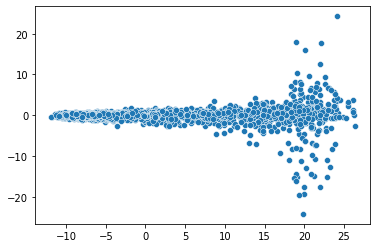

In [20]:
sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

__Question__: What do each point represent? What do the x and y axes represent?

__ANSWER__: Each point represents a word. Explanation for axes are below as a part of the lab:

You might at this point still be confused on what the x- and y- axes represent. Because PCA selects and combines features according to what best describes and models the desired variable, the x and y axes actually don't have an intuitive meaning on a human level. PCA's job is to reduce the dimension of the features, and in this case it manipulated the 100 features each word vector had to just 2 that best described the words we modeled on. So, don't worry too much about what the coordinates of each word represents - we just want you to have a general visual understanding of word vectors and how they may be related to one another on a graph.

On that note, run the following cell. This will label each vector with its respective word. 

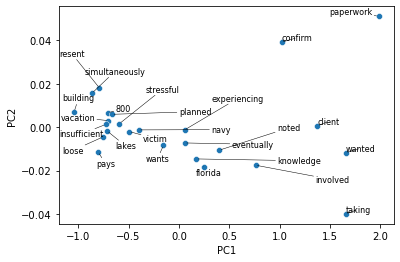

In [21]:
import random
random.seed(10)
rando = random.sample(list(model.wv.vocab), 25)

X1 = model.wv.__getitem__(rando)
pca1 = PCA(n_components=2)
result = pca.fit_transform(X1)
result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

from adjustText import adjust_text
texts = []

# Append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## t-SNE

Another popular unsupervised method for summarizing and visualizing word embeddings is [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). We won't get into the details here, but the basic method involves:

1. Estimating the joint probability estimating the distance between each pair of points, assuming a Gaussian distribution.
2. Project the data into 1-dimension, and then estimate the joint probability of the distance between each pair of points assuming a Student's t-distribution.
3. Use gradient descent to update the second distribution to become similar to the first one.

The basic idea behind this two-step procedure is that we search for the the best lower dimensional representation that gets closest to modeling the original distances in higher dimensional space.

In [22]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

(2759, 100)

C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


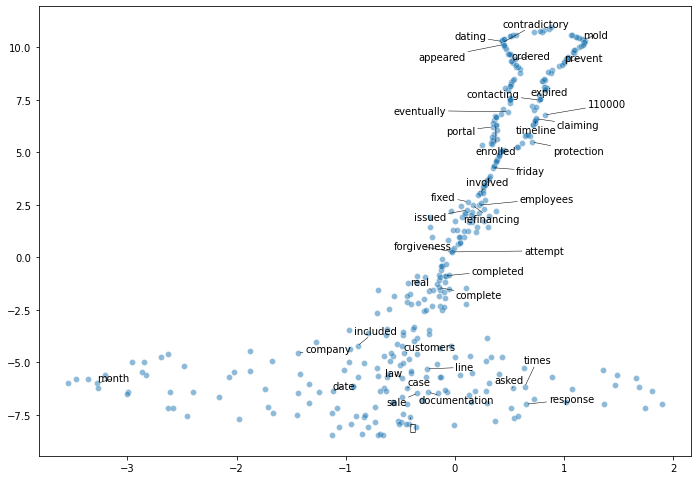

In [23]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Use adjustText to jitter the labels
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Challenge: t-SNE hyperparameters

Try playing with the hyperparameters to see if you can get a different looking plot. Why might this be a problem for interpretability or inference?

C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


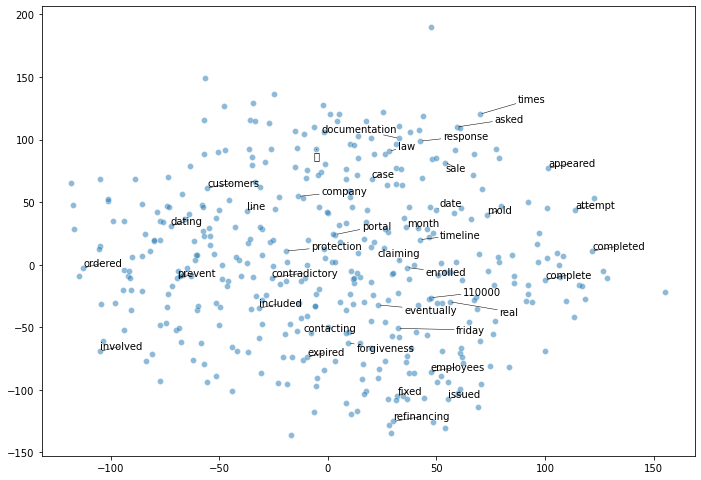

In [24]:
# Initialize t-SNE
tsne = TSNE(n_components = 3, init = 'random', random_state = 10, perplexity = 40)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Use adjustText to jitter the labels
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Averaging Word Embeddings

You'll notice that right now each token is represented by a 100-dimensional array. If we passed these directly to a classification algorithm our feature space would get very high dimensional quickly! A common practice to avoid this problem is to average the word embeddings somehow. You might have heard of variations of word2vec like sent2vec and par2vec which creates embeddings for sentences and paragraphs. We'll introduce a similar method below, but one straightforward way to do this without a fancy new model is to simply average the word embeddings at the document level.

To get a sense of how this works, let's look at how many tokens we have in our first document:

In [25]:
len(cfpb['tokens'][0])

223

223 - but remember not all documents will have vectors associated with them if do not meet word2vec's criteria. Let's see how many we have that are in our model's vocabulary:

In [26]:
doc = [word for word in cfpb['tokens'][0] if word in model.wv.vocab]
len(doc)

195

195! Looks like quite a few tokens didn't make it into the model. Let's look at a few that did: 

In [27]:
doc[0:5]

['contacting', 'ocwen', 'mortgage', 'phh', 'mortgage']

Let's look at the array for 'contacting'. Notice that it is represented by a 100-dimensional array. 

In [28]:
print(model.wv.__getitem__('contacting'))
print(model.wv.__getitem__('contacting').shape)

[ 0.06222892  0.07270495 -0.1866016   0.00932402 -0.18386105 -0.0079787
 -0.2032466  -0.19316058  0.15849155 -0.0391131   0.07597816 -0.08972884
 -0.07143395  0.0520048   0.02859898  0.03362587  0.19424336  0.12454052
 -0.01268326 -0.04370785  0.0572099   0.17538089  0.01594664 -0.04363149
 -0.01959662  0.12967806 -0.001903    0.04966731 -0.08623469  0.07008895
  0.1213839  -0.21467556 -0.115464   -0.12924625 -0.15978757 -0.05012144
 -0.24152713  0.11304144  0.0354337  -0.18473585 -0.12727992  0.0625931
 -0.19388579  0.03088373 -0.02381546  0.02599698 -0.11625179  0.07210856
 -0.02938285  0.01308122 -0.02722728  0.14386405 -0.02366744  0.05157864
  0.20706576  0.08585052 -0.05028023 -0.01967476  0.0475462  -0.05924322
  0.05485205 -0.09306999  0.05530644  0.1549185  -0.07628828 -0.09128502
 -0.12322228  0.21088472 -0.0585065   0.0517907   0.08167747 -0.10583123
 -0.24747309 -0.05892639  0.12479972 -0.07381279  0.0763091  -0.06671801
 -0.0844204  -0.05510867  0.07311456  0.0675733  -0.1

Now let's grab the first vector each token and take their mean:

In [29]:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

0.13807523

And then let's do this for every token and document in our corpus:

In [30]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [31]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in cfpb['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [32]:
doc_average_embeddings

array([[ 0.13807523,  0.18002659, -0.44256487, ...,  0.09859895,
        -0.40823862, -0.46075216],
       [ 0.13432455,  0.17487226, -0.43812656, ...,  0.09528687,
        -0.39410344, -0.4535385 ],
       [ 0.11706215,  0.15460284, -0.3714499 , ...,  0.08332176,
        -0.3383554 , -0.39290297],
       ...,
       [ 0.12936334,  0.19413935, -0.46719283, ...,  0.11430767,
        -0.4180023 , -0.491267  ],
       [ 0.15243055,  0.19798797, -0.4693576 , ...,  0.10013835,
        -0.4551351 , -0.4824489 ],
       [ 0.14987405,  0.20451874, -0.48347902, ...,  0.10696243,
        -0.4505384 , -0.50350595]], dtype=float32)

Ultimately we get an array with `n` rows and 100 columns:

In [33]:
doc_average_embeddings.shape

(1000, 100)

## doc2vec

Document averaged word embeddings tend to perform well with downstream prediction tasks, but there are other options as well. Here, we'll take a look at Doc2Vec. 

We're getting close to classifying, and this is a good point to do our train/test splits. While normally we recommend waiting to do splits until after all preprocessing is done, in this case it will be easier to do the split now because of the way the `TaggedDocument` class works. Let's take a look:

In [34]:
# binarize label
lb_style = LabelBinarizer()
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])

# train/test split
train, test = train_test_split(cfpb, test_size=0.2, random_state=42)
train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,tokens,Product_binary
29,01/23/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Keep getting calls about your loan,I called Bass and Associates in XX/XX/XXXX and...,None,"Bass & Associates, P.C., Attorneys at Law",DC,200XX,None,Consent provided,Web,01/23/20,Closed with explanation,Yes,NaN,3506557,"[called, bass, associates, company, claim, stu...",1
535,02/11/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I have been working with Premier Student Loan ...,None,Premier Student Loan Center,ND,585XX,None,Consent provided,Web,02/11/20,Untimely response,No,NaN,3528302,"[working, premier, student, loan, center, , p...",1
695,01/06/20,Mortgage,Other type of mortgage,Trouble during payment process,None,Back in the beginning of 2019 ( XXXX ) notific...,Company believes complaint is the result of an...,Ditech Financial LLC,FL,320XX,None,Consent provided,Web,01/06/20,Closed with explanation,Yes,NaN,3486795,"[beginning, 2019, , , notification, sent, di...",0
557,04/30/20,Mortgage,Conventional home mortgage,Trouble during payment process,None,My loan was sold to this company. They have 'f...,Company has responded to the consumer and the ...,Specialized Loan Servicing Holdings LLC,AZ,852XX,None,Consent provided,Web,04/30/20,Closed with explanation,Yes,NaN,3631157,"[loan, sold, company, fees, , disclosed, loan...",0
836,02/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,None,"Mortgage is delinquent by {$14000.00}, working...",Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",PA,None,Older American,Consent provided,Web,02/15/20,Closed with explanation,Yes,NaN,3532998,"[mortgage, delinquent, 1400000, working, loss,...",0


After we do our train test splits, we apply the `TaggedDocument()` function to every token. This allows us to associate each document with the class that we want to predict later:

In [35]:
cfpb_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.Product_binary]), axis=1)
cfpb_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.Product_binary]), axis=1)

cfpb_train_tagged[0]

TaggedDocument(words=['contacting', 'ocwen', 'mortgage', 'phh', 'mortgage', 'avail', 'expressed', 'concern', 'extent', 'damage', 'house', 'severe', 'termite', 'infestation', 'mold', 'mildew', 'continued', '2200000', 'dollars', 'mortgage', 'payments', 'house', 'water', 'called', 'backs', 'approved', 'loan', 'refinancing', 'told', 'lender', 'house', 'renovated', 'house', 'flooded', 'continued', 'payments', 'living', 'house', 'deemed', 'uninhabitable', 'unsafe', 'structural', 'integrity', 'house', 'invested', 'walk', 'away', 'property', '\r\n', 'flood', 'insurance', 'house', '24yrs', '\r\n', 'submitted', 'pictures', 'damage', 'caused', 'termites', 'thing', 'mortgage', 'companies', 'interested', 'mortgage', 'monthly', 'payments', 'submitted', 'supporting', 'documentation', 'work', 'related', 'injuries', 'sustained', 'job', 'working', 'waiting', 'help', 'restore', 'louisiana', 'program', 'gotten', 'help', 'restore', 'louisiana', 'program', 'fixed', 'house', 'sold', 'choosing', 'told', 'ocwe

We're now ready to train our doc2vec! One of the key features of gensim is that it natively allows multicore processing - meaning it can take advantage of your CPU cores. Note that this is slightly different from tensorflow that we covered last semester, which also allows GPU acceleration. You can check how many CPU cores you have available: 

In [36]:
cores = multiprocessing.cpu_count()
cores

4

[Parallel processing](https://en.wikipedia.org/wiki/Parallel_computing) is an important topic in computational social science - it will be the key to speeding up lots of different operations. In general, we recommend that whenever you use parallel processing you reserve 1 CPU core for your computer's other functions (keeping your browser and other software running), and use the remaining for your task at hand. In this case, doc2vec's training process is an example of [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) meaning that the different CPUs don't need to talk to each other to do their computations. They can independently work and combine the results at the end. In this case, we are working with very few observations (just 1000), but this is a useful technique to keep in mind for your projects and research! 

First we'll train the model (notice the use of the [`tqdm`](https://tqdm.github.io/) library for progerss bars):

In [37]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores - 1)
model_dbow.build_vocab([x for x in tqdm(cfpb_train_tagged.values)])

100%|██████████| 800/800 [00:00<00:00, 810102.17it/s]


We'll allow the model to train for 30 iterations (epochs - this is the same as our neural nets lab):

In [38]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(cfpb_train_tagged.values)]), 
                     total_examples=len(cfpb_train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 800/800 [00:00<00:00, 399743.05it/s]


Finally, we'll define a function that will grab the embeddings for each document:

In [39]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

## Classification

And finally, let's use logistic regression to see how well our document embeddings do:

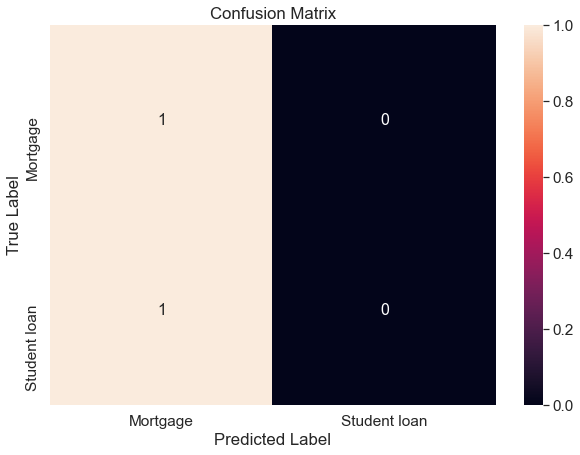

In [40]:
y_train, X_train = vec_for_learning(model_dbow, cfpb_train_tagged)
y_test, X_test = vec_for_learning(model_dbow, cfpb_test_tagged)
logit_reg = LogisticRegression()
logit_model = logit_reg.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Mortgage", 1: "Student loan"})
df_cm.index = ["Mortgage", "Student loan"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Hmm, not as well as we might think! But this shouldn't be too surprising with a small dataset - word embeddings tend to work best when given lots of data.

## Loading Pre-Trained Embeddings

So far we have been working with embeddings trained on our particular corpus. However, this is not usually standard - as you saw above, word2vec works best when it has lots of data. The problem is that training state-of-the-art models requires intense computational resources. It also has a [large carbon footprint](https://arxiv.org/pdf/1906.02243.pdf). Luckily, we can use pre-trained models like Google News or Stanford's GloVe. Note to run this next chunk of code, you need to have the [GoogleNews embeddings](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) in your "data" directory in this repo.

In [41]:
model = gensim.models.KeyedVectors.load_word2vec_format('../../data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

We can also tune the Google News embeddings to a domain-specific corpus. This may or may not be necessary depending on how specific or unique you think words in your corpus might be:

In [42]:
# retrain cfpb['tokens'] model so it has the same dimensions as the google vector
word2vec_model = gensim.models.Word2Vec(size = 300, window=5, min_count = 1, workers = 3)
 
word2vec_model.build_vocab(cfpb['tokens'])
 
# set lockf = 1 to allow updating
 
word2vec_model.intersect_word2vec_format('../../data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
 
# Finish training model
word2vec_model.train(cfpb['tokens'], total_examples=3, epochs = 5)

(538180, 613895)

## Challenge

Repeat the exploration we did in the first part where we trained word embeddings with the new Google model. Do you notice any differences? Create document averaged word embeddings and predict our outcome ('Product_binary'). How did this compare to dov2vec?

### Challenge Embeddings 

In [43]:
# New syntax as of gensim 4.0.0
# model['account'] works for 3.8.3
print(word2vec_model.wv.__getitem__(['account']))

[[ 0.00080236  0.07900371  0.05730697 -0.18751104 -0.2087592   0.1348317
   0.34307906 -0.10666429  0.5559722   0.00321964 -0.06037361 -0.20367664
  -0.20672521  0.15851986 -0.22710745  0.287814    0.20966972  0.1249784
  -0.08833747  0.04792136  0.2309284  -0.02927188  0.0380289  -0.00932912
   0.19578674 -0.1306394  -0.52798676  0.07438201 -0.00928011  0.18755646
  -0.4145215  -0.379113   -0.02407573  0.13686547 -0.05803383 -0.28106588
   0.20493215 -0.18964347  0.00076712  0.08426043  0.30711588 -0.13036458
   0.2933917  -0.16439842 -0.1348929  -0.57745385  0.02790988  0.14224978
  -0.3639214  -0.07302288  0.08875476 -0.27554402 -0.12321724 -0.22029456
   0.00408449  0.23346323 -0.4822386  -0.09669394  0.18523106 -0.51964056
  -0.18216863  0.0835755  -0.10742496  0.08442616 -0.12457746  0.16099879
  -0.10358389  0.21485485 -0.04690796 -0.06355643 -0.03512956  0.07350858
   0.68269384 -0.13940462 -0.21018831  0.06089163  0.3489131   0.32610074
   0.06334504  0.13399082  0.10459662 -0

Check out the shape of the vectors for 'account', what do you notice?

In [44]:
word2vec_model.wv.__getitem__(['account']).shape

(1, 300)

**Answer**: There are 100 elements in this array. Notice that this was one of the parameters we set in the training process!

Use the following empty cells to look at what the word embeddings look like for words you think may appear in the text! Keep in mind that even if a word shows up in the text as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. 

In [45]:
# word 1
word2vec_model.wv.__getitem__(['navient'])

array([[ 0.01760665,  0.06796604,  0.01939214,  0.04701132, -0.07754191,
        -0.04232756,  0.13974214, -0.06729741,  0.22101106,  0.03081006,
        -0.08771052, -0.15883578, -0.08966056,  0.09546042, -0.17096174,
         0.18032236,  0.11923913,  0.09555072, -0.03131969, -0.02362959,
         0.03980338,  0.06137112,  0.03568446, -0.00473613,  0.050503  ,
        -0.05475934, -0.11825762,  0.06376473, -0.00297384,  0.00223617,
        -0.01556107, -0.11583964, -0.01959482, -0.01813675,  0.02007046,
        -0.03892931,  0.08895248, -0.01092893,  0.02782909,  0.03431797,
         0.10860227, -0.0391878 ,  0.13824297, -0.09499046, -0.12847358,
        -0.18269043, -0.04492786,  0.00214059, -0.14970677,  0.04331064,
         0.0080587 , -0.06026798, -0.03508521, -0.04813206, -0.0300841 ,
         0.0894368 , -0.14843796, -0.07527386,  0.04069094, -0.16935518,
        -0.06237349,  0.13730755, -0.17833577, -0.04553387, -0.03186456,
        -0.06575274, -0.09187438,  0.1408043 , -0.0

In [46]:
# word 2
word2vec_model.wv.__getitem__(['company'])

array([[ 0.02113209,  0.00952065, -0.06367148, -0.00744934, -0.07217893,
        -0.09493179,  0.4308613 , -0.05252641,  0.43789083,  0.00915791,
        -0.24488331, -0.10553054, -0.0480679 , -0.01830361, -0.7009757 ,
         0.3625516 ,  0.22276875,  0.06572403, -0.09067164, -0.0360916 ,
         0.09184665,  0.14194186, -0.08235307, -0.11417717,  0.12270395,
        -0.00999903, -0.19274023,  0.30338454,  0.08074961, -0.21409445,
         0.08311667, -0.34823585, -0.12351917,  0.08040073,  0.11046685,
        -0.03330756,  0.39840773, -0.0937051 ,  0.1123369 ,  0.08308148,
         0.28939632,  0.0571074 ,  0.39089262, -0.09251479, -0.54620254,
        -0.53756845, -0.07196799,  0.12819757, -0.41888267,  0.09447931,
         0.36449608, -0.10454963,  0.11594452, -0.17657869,  0.04356484,
         0.15239383, -0.37265962, -0.13965371,  0.18763591, -0.26847744,
        -0.09235724,  0.3203083 , -0.5208206 , -0.02481073, -0.15489796,
        -0.10329609, -0.25552878,  0.23443937, -0.0

In [47]:
# word 3 
word2vec_model.wv.__getitem__(['credit'])

array([[-6.46737823e-03,  3.24590772e-01,  3.47585157e-02,
         1.37271672e-01,  1.34193733e-01, -8.50099623e-02,
         2.81841129e-01, -2.18490526e-01,  6.06105387e-01,
        -1.90166190e-01, -4.40210134e-01, -4.66483921e-01,
        -2.53004849e-01,  3.97444397e-01, -5.07484794e-01,
         3.95459384e-01,  5.85704625e-01,  2.93658972e-01,
        -5.58054037e-02, -1.46478251e-01,  1.51027024e-01,
         1.88187912e-01,  1.67396501e-01, -2.27346361e-01,
         3.21766227e-01, -2.82849610e-01, -1.08220279e-01,
        -1.76630110e-01,  2.63333082e-01,  2.03778386e-01,
        -2.02220395e-01, -1.44211024e-01,  2.98384488e-01,
         1.02012880e-01,  2.79041648e-01,  1.15931258e-01,
        -5.13639152e-02,  1.23498673e-02,  1.58200130e-01,
         1.28069967e-01,  5.35158962e-02, -2.31729612e-01,
         1.99869350e-01, -2.66146779e-01, -2.04385459e-01,
        -3.36340845e-01, -6.17188634e-03,  1.68125749e-01,
        -3.91651779e-01,  2.46463299e-01,  2.99426198e-0

If you're curious, the cell directly below will return a list of words that have been turned into word vectors by the model above:

In [48]:
words = list(word2vec_model.wv.vocab)
print(words[0:100])

['contacting', 'ocwen', 'mortgage', 'phh', 'avail', 'expressed', 'concern', 'extent', 'damage', 'house', 'severe', 'termite', 'infestation', 'mold', 'mildew', 'continued', '2200000', 'dollars', 'payments', 'water', 'called', 'backs', 'approved', 'loan', 'refinancing', 'told', 'lender', 'renovated', 'flooded', 'living', 'deemed', 'uninhabitable', 'unsafe', 'structural', 'integrity', 'invested', 'walk', 'away', 'property', '\r\n', 'flood', 'insurance', '24yrs', 'submitted', 'pictures', 'caused', 'termites', 'thing', 'companies', 'interested', 'monthly', 'supporting', 'documentation', 'work', 'related', 'injuries', 'sustained', 'job', 'working', 'waiting', 'help', 'restore', 'louisiana', 'program', 'gotten', 'fixed', 'sold', 'choosing', 'desire', 'helping', 'homeowners', 'homes', 'foreclosure', 'auctions', 'bid', 'offered', 'chance', 'refinance', 'involved', 'given', 'modification', 'forbearance', 'parties', 'mentioned', 'aware', 'newrez', 'contacted', 'interest', 'asked', 'send', 'packet

`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `credit` and `debt`:

In [49]:
# New syntax as of gensim 4.0.0
# model.similarity() works as of 3.8.3
word2vec_model.wv.similarity('credit', 'debt')

0.70600367

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [50]:
# Similarity between credit/debt and loan/mortgage
word2vec_model.wv.n_similarity(['credit','debt'],['loan','mortgage'])

0.8626909

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away. Out of the three words in the list `['credit', 'loan', 'student']`, which is the furthest vector from the mean?

In [51]:
# New syntax for 4.0.0 requires passing a tuple ()  a list []
# ['credit', 'loan', 'student'] works for 3.8.3
word2vec_model.wv.doesnt_match(['credit', 'loan', 'student'])

C:\Users\Anike\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'student'

In [52]:
word2vec_model.wv.doesnt_match(('pandemic', 'covid', 'bank'))

'pandemic'

The most famous implementation of this vector math is semantics. What happens if we take:

$$\vec{house} - \vec{rent} + \vec{loan} = $$

In [53]:
word2vec_model.wv.most_similar(positive=['house', 'loan'], negative=['rent'])

[('24', 0.7875536680221558),
 ('cfpb', 0.7870694398880005),
 ('rmf', 0.7857356667518616),
 ('santander', 0.7846701741218567),
 ('xxxx20', 0.7844319343566895),
 ('bleive', 0.7839900255203247),
 ('pslf', 0.7837351560592651),
 ('14', 0.783545732498169),
 ('  ', 0.7834033966064453),
 ('fedloan', 0.7826071381568909)]

### Challenge PCA

Next we will explore the word embeddings of our `text` visually with PCA. 

We can retrieve __all__ of the vectors from a trained model as follows:

In [54]:
X = word2vec_model.wv.__getitem__(word2vec_model.wv.vocab)

As we do with non-text features, we want to standardize X so that all features have the same scale. Do this by creating a StandardScaler(), then run its fit_transform method on X. 

In [55]:
# scale the data
X_std = StandardScaler().fit_transform(X)

In [56]:
# make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = pca.fit_transform(X_std)

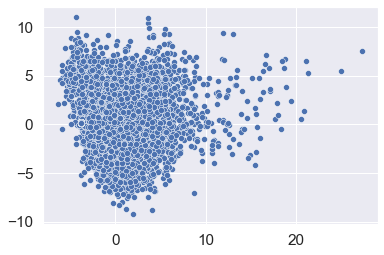

In [57]:
sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

<ipython-input-58-07adbebb8e88>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  rando = random.sample(list(model.wv.vocab), 25)
<ipython-input-58-07adbebb8e88>:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  X1 = model.wv.__getitem__(rando)


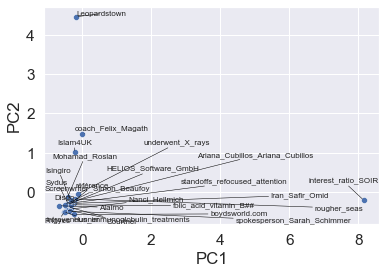

In [58]:
import random
random.seed(10)
rando = random.sample(list(model.wv.vocab), 25)

X1 = model.wv.__getitem__(rando)
pca1 = PCA(n_components=2)
result = pca.fit_transform(X1)
result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

from adjustText import adjust_text
texts = []

# Append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### Challenge t-SNE

In [59]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [word2vec_model.wv.__getitem__(word) for word in words if word in word2vec_model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in word2vec_model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

(8447, 300)

C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


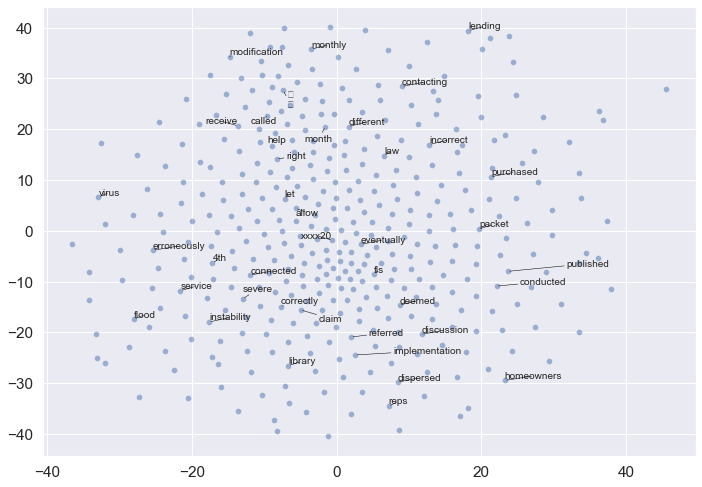

In [60]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anike\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


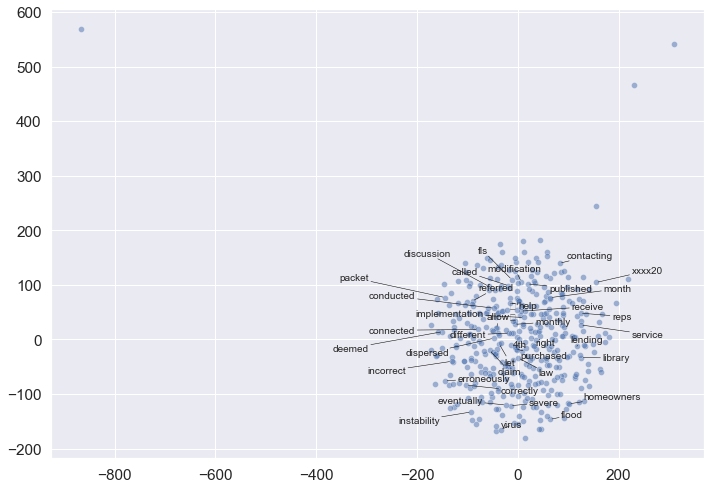

In [61]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 3, init = 'random', random_state = 10, perplexity = 40)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Averaging Word Embeddings

And then let's do this for every token and document in our corpus:

In [62]:
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [63]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in cfpb['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(word2vec_model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

<ipython-input-62-651f94665129>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  doc = [word for word in doc if word in model.wv.vocab]


In [64]:
doc_average_embeddings

array([[ 0.05258872,  0.11295668,  0.00942947, ..., -0.04350779,
         0.01313663, -0.1504578 ],
       [ 0.06251753,  0.09325808,  0.09939288, ..., -0.12553547,
        -0.05908825, -0.12370634],
       [ 0.00298901,  0.08213148,  0.00868453, ..., -0.06096444,
        -0.01592281, -0.09394466],
       ...,
       [-0.00456962,  0.0576648 ,  0.0622672 , ..., -0.14056501,
        -0.0426355 , -0.11479055],
       [-0.00476751,  0.11453436,  0.01222327, ..., -0.038703  ,
        -0.02009727, -0.16169578],
       [ 0.03170422,  0.09638249,  0.03666608, ..., -0.11048961,
         0.03040555, -0.11530895]], dtype=float32)

### Challenge: Classification

In [65]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

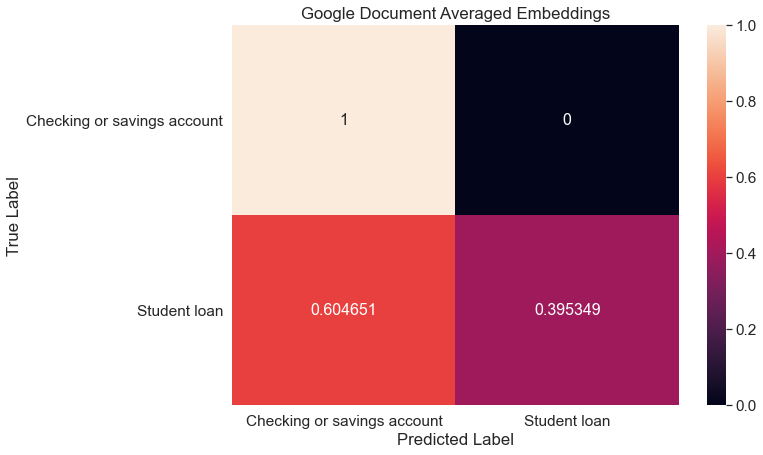

In [66]:
y = cfpb['Product_binary']

X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Checking or savings account", 1: "Student loan"})
df_cm.index = ["Checking or savings account", "Student loan"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Discussion

You've now had a gentle introduction to word embeddings! There are a few major lessons here. Word embeddings are powerful and capture a lot of context that frequency based embeddings do not. However, this isn't perfect! And as with any machine learning application, your choice of model and hyperparameters can matter quite a lot. In this case, some of our simpler featurizations and models actually did better than word embeddings, but this won't always be true. It is also worth learning more about other embeddings like [GloVe](https://nlp.stanford.edu/projects/glove/), transformer based models like [BERT](https://arxiv.org/abs/1810.04805) and deep learning approaches like [ELMo](https://arxiv.org/abs/1802.05365).

---
Notebook developed by Aniket Kesari. Some materials borrowed from [LS123: Data, Prediction, and Law](https://github.com/Akesari12/LS123_Data_Prediction_Law_Spring-2019/blob/master/labs/Word%20Embedding/LEGALST-190%20Word%20Embedding%20SOLUTIONS.ipynb)